#### Import Frameworks

In [1]:
from nltk.corpus import names
import nltk
import numpy as np
import pandas as pd
import random
import seaborn as sns
from matplotlib import pyplot as plt

#### Project Instructions

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?


Source: Natural Language Processing with Python, exercise 6.10.2.

Following initial guidance from NLTK book

#### Randomize Names

In [38]:
labeled_names = ([(name, 'male') for name in names.words('male.txt')]\
                 +[(name, 'female') for name in names.words('female.txt')])
random.shuffle(labeled_names)

len(labeled_names)

7944

#### Set up Test and Train subsets

Since the length of our `labeled_names` data is 7944, we split into training, dev, and test sets at an approximately 81%, 12%, 6% split.

In [21]:
train_names = labeled_names[1500:]
devtest_names = labeled_names[500:1500]
test_names = labeled_names[:500]

#### Preliminary Feature Function for Classification

The first feature classifier consists of pulling 3 elements: first letter of name, last letter of name, and last 2 letters of the name.

In [35]:
def classify_gender1(name):
    features = {}
    features["first_letter"] = name[0].lower()
    features["last_letter"] = name[-1].lower()
    features['last_two_letters'] = name[-2:].lower()
    return features

In [39]:
feature1 = [(classify_gender1(n), gender) for (n, gender) in train_names]
classifier = nltk.NaiveBayesClassifier.train(feature1)

test_feature = [(classify_gender1(n),gender) for (n,gender) in devtest_names]
print(nltk.classify.accuracy(classifier, test_feature))

0.805


Overall, the NLTK textbook suggestions proposed using some of the first and last letters as features to predict gender performs reasonably well on the devtest data set. There are definitely ways to improve the model and the below will an attempt to feature engineer beyond what was proposed in the textbook. That iteration of a model is a good first step in the process to building out a gender classifier

#### Reviewing Incorrect Predictions

In [43]:
errors2 = []
for (name, tag) in devtest_names:
 #   devt = [(classify_gender1(n), gender) for (n, gender) in devtest_names]
    guess = classifier.classify(classify_gender1(name))
    if guess != tag:
        errors2.append( (tag, guess, name) )
        
errors2[:10]

[('female', 'male', 'Zoe'),
 ('female', 'male', 'Maridel'),
 ('female', 'male', 'Penny'),
 ('male', 'female', 'Irvine'),
 ('female', 'male', 'Flo'),
 ('female', 'male', 'Ambur'),
 ('female', 'male', 'Jessalin'),
 ('male', 'female', 'Arie'),
 ('female', 'male', 'Renel'),
 ('male', 'female', 'Alley')]

Using the textbook provided process to review names that were incorrectly classified by the model

In [49]:
gend2 = pd.DataFrame(data=errors2,columns=['label','pred','name_input'])
gend2['firstone'] = gend2['name_input'].apply(lambda x: x[0])
gend2['lasttwo'] = gend2['name_input'].apply(lambda x: x[-2:])
gend2['lastone'] = gend2['name_input'].apply(lambda x: x[-1])
gend2.shape

(195, 6)

In [50]:
gend2.head(20)

,label,pred,name_input,firstone,lasttwo,lastone
0,female,male,Zoe,Z,oe,e
1,female,male,Maridel,M,el,l
2,female,male,Penny,P,ny,y
3,male,female,Irvine,I,ne,e
4,female,male,Flo,F,lo,o
5,female,male,Ambur,A,ur,r
6,female,male,Jessalin,J,in,n
7,male,female,Arie,A,ie,e
8,female,male,Renel,R,el,l
9,male,female,Alley,A,ey,y


Pulling into the dataframe to be able to review some of the common patterns which were incorrect. This could help trying to come up with new features that might further improved the model performance

For example, we can sample names that end with "en"

In [51]:
[(name,gend)for name,gend in train_names if name[-2:]=='en'][:20]

[('Glen', 'female'),
 ('Karlen', 'female'),
 ('Koren', 'female'),
 ('Nelsen', 'male'),
 ('Stephen', 'male'),
 ('Kirsten', 'female'),
 ('Darren', 'male'),
 ('Pegeen', 'female'),
 ('Aleen', 'female'),
 ('Caren', 'female'),
 ('Maximilien', 'male'),
 ('Hamlen', 'male'),
 ('Warren', 'male'),
 ('Morten', 'male'),
 ('Katleen', 'female'),
 ('Kellen', 'male'),
 ('Regen', 'male'),
 ('Keren', 'female'),
 ('Sven', 'male'),
 ('Maryellen', 'female')]

#### Exploring  if larger n-grams might help gender classification

Based on the charts, it would appear that there may be a little more stratification between the genders for 3-grams than 4-grams.

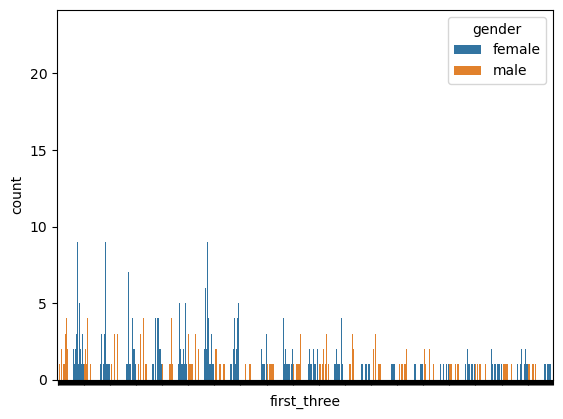

In [52]:
first_three = [(g,n[:3]) for n,g in devtest_names]
firstthree_df = pd.DataFrame(first_three,columns=['gender','first_three'])
sns.countplot(x='first_three',data=firstthree_df,hue='gender',orient='v').set(xticklabels=[])
#plt.xticks(rotation=90)
plt.show();

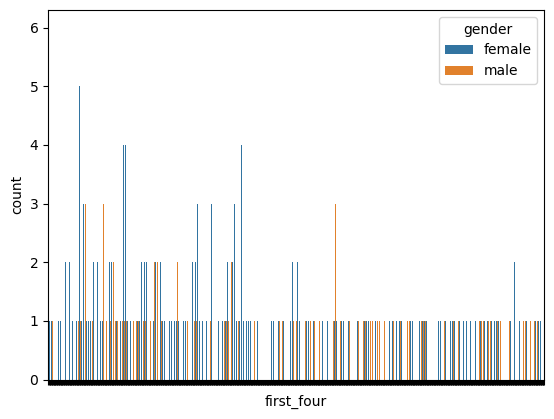

In [53]:
first_four = [(g,n[:4]) for n,g in devtest_names]
firstfour_df = pd.DataFrame(first_four,columns=['gender','first_four'])
sns.countplot(x='first_four',data=firstfour_df,hue='gender',orient='v').set(xticklabels=[])
#plt.xticks(rotation=90)
plt.show();

#### Next classifier - using first letter, last letter, last two letters, first three letters, and first four letters.

We combine our previous features with both the 3-gram and 4-gram features.

In [55]:
def classify_gender2(name):
    features = {}
    features["first_letter"] = name[0].lower()
    features["last_letter"] = name[-1].lower()
    features['last_two_letters'] = name[-2].lower()
    features['first_three_letters'] = name[:3].lower()
    features['first_four_letters'] = name[:4].lower()
    return features

In [64]:
feature2 = [(classify_gender2(n), gender) for (n, gender) in train_names]
classifier = nltk.NaiveBayesClassifier.train(feature2)

devtest_feature2 = [(classify_gender2(n),gender) for (n,gender) in devtest_names]
print(nltk.classify.accuracy(classifier, devtest_feature2))

0.839


This doesn't do much on the dev_test data...

In [60]:
test2_feature = [(classify_gender2(n),gender) for (n,gender) in test_names]
#test2_feature_dict = {(classify_gender2(n),gender) for (n,gender) in test_names}
print(nltk.classify.accuracy(classifier, test2_feature))

0.828


By adding a larger initial n-gram (3 & 4 letters) the model accuracy went up only slightly from the initial iteration of the model. One potential risk with the additional features added is that the first four letters could have some overlap with the first three letters feature. As the textbook suggested this may cause some overweighting given that naive bayes treats each feature as independent from the others.

#### Next classifier - adding vowels and length of the name.

In [62]:
def classify_gender3(name):
    features = {}
    features["first_letter"] = name[0].lower()
    features["last_letter"] = name[-1].lower()
    features['last_two_letters'] = name[-2].lower()
    features['first_three_letters'] = name[:3].lower()
    features['first_four_letters'] = name[:4].lower()
    features['vowels'] = len([let for let in name if let.lower() in 'aeiou'])
    features['length'] = len(name)
    return features

In [65]:
feature3 = [(classify_gender3(n), gender) for (n, gender) in train_names]
classifier = nltk.NaiveBayesClassifier.train(feature3)

devtest_feature3 = [(classify_gender3(n),gender) for (n,gender) in devtest_names]
print(nltk.classify.accuracy(classifier, devtest_feature3))

0.846


In [66]:
test_feature3 = [(classify_gender3(n),gender) for (n,gender) in test_names]
print(nltk.classify.accuracy(classifier, test_feature3))

0.81


Despite the additional features it does not appear to add any predictive power to the model and a simpler one would suffice and potentially extrapolate as well as the third iteration of the model. Perhaps this is due to the fact that the features were more generic to any name and less reliant of n-gram patterns. Given the performance of the model, it may not make sense to overfit it any further as these fairly basic features, in classify_gender2, are able to extrapolate fairly well to the test set.

#### Applying the same model to a decision tree

In [69]:
classifier_dt = nltk.DecisionTreeClassifier.train(feature1)

nltk.classify.accuracy(classifier_dt, devtest_feature)

0.636

This model applied with an alternative classifier algorithm does not appear to be doing well at all. Let's try the additional features to see if it adds impact

In [71]:
classifier_dt = nltk.DecisionTreeClassifier.train(feature2)

nltk.classify.accuracy(classifier_dt, devtest_feature2)

0.709

In [72]:
classifier_dt = nltk.DecisionTreeClassifier.train(feature3)

nltk.classify.accuracy(classifier_dt, devtest_feature3)

0.71

The additional features do appear to be adding at least some value to the Decision tree, but as with the Bayes, only the 2nd set of features (not the addition of vowels and names) makes a notable difference.

#### Exploring Base Decision Tree Rules

In [84]:
print(classifier_dt.pseudocode(depth=4)[:1500])

if first_four_letters == 'abag': return 'female'
if first_four_letters == 'abbe': return 'male'
if first_four_letters == 'abbi': return 'male'
if first_four_letters == 'abbo': return 'male'
if first_four_letters == 'abby': return 'female'
if first_four_letters == 'abdu': return 'male'
if first_four_letters == 'abe': return 'male'
if first_four_letters == 'abel': return 'male'
if first_four_letters == 'abig': return 'female'
if first_four_letters == 'abne': return 'male'
if first_four_letters == 'abra': return 'male'
if first_four_letters == 'acac': return 'female'
if first_four_letters == 'ace': return 'male'
if first_four_letters == 'ada': return 'female'
if first_four_letters == 'adah': return 'female'
if first_four_letters == 'adai': return 'male'
if first_four_letters == 'adal': return 'female'
if first_four_letters == 'adam': return 'male'
if first_four_letters == 'adar': return 'female'
if first_four_letters == 'addi': return 'female'
if first_four_letters == 'adel': return 'fema

Many of the highest level rules are based on the first four letters and may be weaning out other more valuable features that exist. Let's try eliminating that feature to see how impacts the model

In [77]:
def classify_gender4(name):
    features = {}
    features["first_letter"] = name[0].lower()
    features["last_letter"] = name[-1].lower()
    features['last_two_letters'] = name[-2].lower()
    features['first_three_letters'] = name[:3].lower()
    #features['first_four_letters'] = name[:4].lower()
    features['vowels'] = len([let for let in name if let.lower() in 'aeiou'])
    features['length'] = len(name)
    return features

In [78]:
feature5 = [(classify_gender4(n), gender) for (n, gender) in train_names]
classifier_dt2 = nltk.DecisionTreeClassifier.train(feature5)

devtest_feature4 = [(classify_gender4(n),gender) for (n,gender) in devtest_names]
print(nltk.classify.accuracy(classifier_dt2, devtest_feature4))

0.728


In [79]:
dt_test_feature = [(classify_gender4(n),gender) for (n,gender) in test_names]
nltk.classify.accuracy(classifier_dt2, dt_test_feature)

0.738

There is slight improvement in the accuracy of the model by eliminating the first four letter feature. Let's review the top level decision trees leafs to determine if additional modifications are needed

In [83]:
print(classifier_dt2.pseudocode(depth=4)[:1500])

if first_three_letters == 'aba': return 'female'
if first_three_letters == 'abb': 
  if last_letter == 'e': return 'male'
  if last_letter == 't': return 'male'
  if last_letter == 'y': return 'female'
if first_three_letters == 'abd': return 'male'
if first_three_letters == 'abe': return 'male'
if first_three_letters == 'abi': return 'female'
if first_three_letters == 'abn': return 'male'
if first_three_letters == 'abr': return 'male'
if first_three_letters == 'aca': return 'female'
if first_three_letters == 'ace': return 'male'
if first_three_letters == 'ada': 
  if last_letter == 'a': return 'female'
  if last_letter == 'e': return 'female'
  if last_letter == 'h': return 'female'
  if last_letter == 'm': return 'male'
  if last_letter == 'r': return 'male'
  if last_letter == 's': return 'male'
if first_three_letters == 'add': return 'female'
if first_three_letters == 'ade': return 'female'
if first_three_letters == 'adg': return 'male'
if first_three_letters == 'adi': 
  if last_tw

The higher level leaves of this decision tree appear more varied than the last review although the performance of the model is substantially lower than when using Naive Bayes